# Part IV: Validation and Testing

Date: 23/08/2022

Authors: Jordi Bolibar & Facundo Sapienza

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

# Setup

The goal of this notebook is to explore different validation and testing methodologies that you can use and the respective considerations you have to consider at the moment of asserting the performace of a given model, either for model selection or test report. 

When training and testing a model, we usually split the dataset among three different sets: training, validation and testing set. Sometimes, this split of the data is done authomatically by the method we use, and sometimes instead of a simple split of the dataset into three pieces is done iteratively (eg, in k-fold cross-validation). Independently of how we implement this, we need to understand the limitations and considerations we need to have at the moment we do the split. This considerations can include:
- Sampling procedure
- Spatial and temporal correlations between data points
- Size of data available
- Nature of the datasets: where are they coming from? How independent they are?

### [ **Exercice 3** ]
<img src="Figures/eye_logo.png" width="75"/>

How would you desing a validation-testing workflow for the problem of predicting the mass balance? How would you divide the different folds?

For an excellent introduction to cross-validation, as well as the different high-level function to implement it in `sklearn` models, checkout [this tutorial](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [3]:
df_train_all = pd.read_csv('Data/df_train_all.csv', index_col=['rgi_id', 'period'])
df_train_all

PDD   area  icecap     lat     prcp_01  \
rgi_id         period                                                    
RGI60-08.03009 2000-2010  58.347229  0.560     0.0  61.410  180.605754   
               2010-2020  57.499103  0.560     0.0  61.410  177.588855   
RGI60-08.02369 2000-2010  29.322022  0.868     0.0  67.211  100.077741   
               2010-2020  29.845311  0.868     0.0  67.211  106.696440   
RGI60-08.02761 2000-2010  81.774534  1.423     0.0  61.872  157.790569   
...                             ...    ...     ...     ...         ...   
RGI60-08.01280 2010-2020  61.119480  0.095     0.0  66.472  178.777936   
RGI60-08.01101 2000-2010  50.657925  1.190     0.0  61.524  180.333787   
               2010-2020  49.594748  1.190     0.0  61.524  179.886484   
RGI60-08.00321 2000-2010  58.810481  3.371     0.0  61.500  219.850909   
               2010-2020  58.440740  3.371     0.0  61.500  217.887660   

                             prcp_02     prcp_03     prcp_04     prcp_05  \
rgi_id         period                                                      
RGI60-08.03009 2000-2010  179.220350  189.276083  193.833619  125.218186   
               2010-2020  152.698084  197.095410  143.539612  109.205440   
RGI60-08.02369 2000-2010  103.813814  110.801530  108.119632   92.988041   
               2010-2020   88.701531  112.939499   78.565675   78.882801   
RGI60-08.02761 2000-2010  170.811408  189.096644  186.691017  125.473480   
...                              ...         ...         ...         ...   
RGI60-08.01280 2010-2020  144.972057  198.788401  131.487880  124.621465   
RGI60-08.01101 2000-2010  183.899261  195.892988  199.060555  130.992370   
               2010-2020  155.927921  203.959297  147.135021  113.662108   
RGI60-08.00321 2000-2010  220.156427  229.581238  233.757319  154.367752   
               2010-2020  187.402467  239.439860  172.542368  134.047450   

                             prcp_06  ...   temp_09    temp_10    temp_11  \
rgi_id         period                 ...                                   
RGI60-08.03009 2000-2010  110.821174  ...  7.704444  10.274074   9.710740   
               2010-2020  119.362232  ...  7.563333   9.994074   9.414073   
RGI60-08.02369 2000-2010   71.397800  ...  5.204445   8.865555   7.751112   
               2010-2020  102.347588  ...  4.877778   8.712222   7.577778   
RGI60-08.02761 2000-2010  111.741884  ...  8.794815  11.406667  10.830000   
...                              ...  ...       ...        ...        ...   
RGI60-08.01280 2010-2020  135.681207  ...  7.730000  11.023703  10.404444   
RGI60-08.01101 2000-2010  116.113799  ...  6.898888   9.590370   9.018148   
               2010-2020  126.854591  ...  6.749999   9.297037   8.728148   
RGI60-08.00321 2000-2010  135.158211  ...  7.525555  10.165555   9.594814   
               2010-2020  146.167576  ...  7.386666   9.886667   9.329259   

                           temp_12    zmax    zmed    zmin  dmdtda  \
rgi_id         period                                                
RGI60-08.03009 2000-2010  5.632594  1581.0  1534.0  1450.0 -0.8343   
               2010-2020  5.837038  1581.0  1534.0  1450.0 -0.3769   
RGI60-08.02369 2000-2010  3.038889  1284.0  1222.0  1140.0 -0.7524   
               2010-2020  3.988889  1284.0  1222.0  1140.0 -0.4607   
RGI60-08.02761 2000-2010  6.929259  1785.0  1511.0  1147.0 -0.5289   
...                            ...     ...     ...     ...     ...   
RGI60-08.01280 2010-2020  7.191111  1087.0   978.0   896.0 -0.2977   
RGI60-08.01101 2000-2010  5.028519  1682.0  1578.0  1356.0 -0.3273   
               2010-2020  5.244075  1682.0  1578.0  1356.0 -0.8434   
RGI60-08.00321 2000-2010  5.826667  1621.0  1509.0  1141.0 -0.5828   
               2010-2020  6.045556  1621.0  1509.0  1141.0 -0.4431   

                          err_dmdtda  target_id  
rgi_id         period                            
RGI60-08.03009 2000-2010      0.3221   164862.0  
               20

In [4]:
features_to_drop = [ 'dmdtda', 'err_dmdtda', 'target_id']

df_train_all_X = df_train_all.drop(features_to_drop, axis=1)
df_train_all_y = df_train_all[['dmdtda']]

X_train_all, y_train_all = df_train_all_X.values, df_train_all_y.values



In [5]:
scaler = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [6]:
X_train_all_scaled = scaler.transform(X_train_all)


In [14]:
y_train_all = np.ravel(y_train_all)

First we define the neural network architecture:

In [35]:
reg_nn = MLPRegressor(hidden_layer_sizes=(10, 8, 5, 4),
                      activation='relu',
                      solver='adam', 
                      batch_size=50, 
                      max_iter=700,
                      learning_rate='adaptive', 
                      shuffle=True, 
                      validation_fraction=0.1)

And now we search for the best hyperparameters in cross-validation using 10 folds.

In [46]:
%%time
clf = GridSearchCV(reg_nn, {'hidden_layer_sizes': [(10,8,5,4),(50,30,20,10), (30,20,10,5)],
                               'batch_size': [50, 150]}, 
                   cv=10,
                   verbose=1,
                   scoring="neg_mean_squared_error",
                   n_jobs=4)
clf.fit(X_train_all_scaled, y_train_all)

print(clf.best_score_)
print(clf.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
-0.09909672699939523
{'batch_size': 150, 'hidden_layer_sizes': (10, 8, 5, 4)}
CPU times: user 1.2 s, sys: 12.1 ms, total: 1.21 s
Wall time: 56 s


In [47]:
clf.cv_results_['mean_test_score']

array([-0.10429718, -0.12806915, -0.11770636, -0.09909673, -0.12501412,
       -0.10653878])

And now we want to assess the performance of each one of the folds:

In [45]:
scores = cross_val_score(reg_nn, X_train_all_scaled, y_train_all, cv=10, scoring="neg_mean_squared_error")

In [41]:
-scores

array([0.13531495, 0.11917822, 0.12479862, 0.08672007, 0.11514285,
       0.08674603, 0.09609675, 0.11502949, 0.10428792, 0.08864449])

In [48]:
reg_nn.fit(X_train_all_scaled, y_train_all)

MLPRegressor(batch_size=50, hidden_layer_sizes=(10, 8, 5, 4),
             learning_rate='adaptive', max_iter=700)

In [49]:
df_test = pd.read_csv('Data/df_test.csv', index_col=['rgi_id', 'period'])

In [50]:
features_to_drop = ['dmdtda', 'err_dmdtda', 'target_id']

df_test_X = df_test.drop(features_to_drop, axis=1)
df_test_y = df_test[['dmdtda']]

X_test, y_test = df_test_X.values, df_test_y.values

In [54]:
X_test_scaled = scaler.transform(X_test)

In [56]:
reg_nn.score(X_test_scaled, y_test)

0.24385970172963367

In [58]:
def plot_prediction(y1, y2, n_toplot=10**10):
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    plt.figure(figsize=(8,8))
    plt.title("Model Evaluation", fontsize=17)
    plt.ylabel('Modeled SMB (m.w.e)', fontsize=16)
    plt.xlabel('Reference SMB (m.w.e)', fontsize=16)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=20)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    plt.colorbar(sc) 
    lineStart = -2.5
    lineEnd = 1.5
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

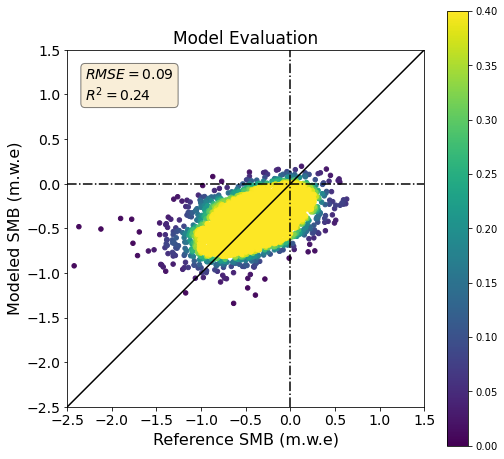

In [59]:
plot_prediction(y_test, reg_nn.predict(X_test_scaled), n_toplot=5000)

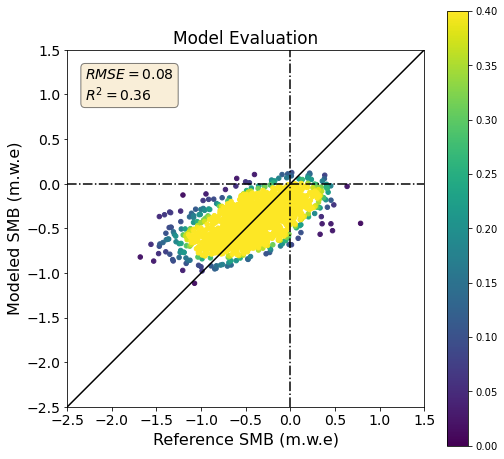

In [60]:
plot_prediction(y_train_all, reg_nn.predict(X_train_all_scaled), n_toplot=5000)

In [61]:
y_train_all


array([-0.8343, -0.3769, -0.7524, ..., -0.8434, -0.5828, -0.4431])

In [62]:
y_train_all.shape


(1802,)

In [63]:
y_test.shape


(4114, 1)

In [64]:
y_test

array([[-0.506 ],
       [-0.0714],
       [-0.7451],
       ...,
       [-0.3939],
       [-0.3783],
       [ 0.0246]])